In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn.model_selection import GroupShuffleSplit, GroupKFold, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import csv

In [2]:
data = pd.read_csv('/Users/larsheijnen/Thesis/data/motor/MDS-UPDRS_Part_III_21Mar2025.csv')

motor_features = [
    'PATNO', 'EVENT_ID', 'INFODT',  # Identifying information

    # MDS-UPDRS Part III scores
    'NP3SPCH', 'NP3FACXP',
    'NP3RIGN', 'NP3RIGRU', 'NP3RIGLU', 'NP3RIGRL', 'NP3RIGLL',  # Rigidity
    'NP3FTAPR', 'NP3FTAPL',  # Finger tapping
    'NP3HMOVR', 'NP3HMOVL',  # Hand movements
    'NP3PRSPR', 'NP3PRSPL',  # Pronation-supination
    'NP3TTAPR', 'NP3TTAPL',  # Toe tapping
    'NP3LGAGR', 'NP3LGAGL',  # Leg agility
    'NP3RISNG',  # Arising from chair
    'NP3GAIT', 'NP3FRZGT',  # Gait and freezing
    'NP3PSTBL',  # Postural stability
    'NP3POSTR',  # Posture
    'NP3BRADY',  # Body bradykinesia
    'NP3PTRMR', 'NP3PTRML',  # Postural tremor
    'NP3KTRMR', 'NP3KTRML',  # Kinetic tremor
    'NP3RTARU', 'NP3RTALU', 'NP3RTARL', 'NP3RTALL', 'NP3RTALJ', 'NP3RTCON',  # Rest tremor
    'NP3TOT'  # Total score (needed for target creation)
]

# Keep only relevant columns available in the dataset
motor_df = data[[col for col in motor_features if col in data.columns]].copy() # Use .copy() to avoid SettingWithCopyWarning
print(f"Initial motor assessment DataFrame shape: {motor_df.shape}")

Initial motor assessment DataFrame shape: (32346, 37)


In [3]:
# Drop rows where NP3TOT is missing (essential for target creation)
motor_df.dropna(subset=['NP3TOT'], inplace=True)
print(f"\nShape after dropping rows with missing NP3TOT: {motor_df.shape}")


Shape after dropping rows with missing NP3TOT: (26109, 37)


In [4]:
motor_df['INFODT'] = pd.to_datetime(motor_df['INFODT'], errors='coerce')
motor_df.dropna(subset=['INFODT'], inplace=True) # Drop rows where date conversion failed
print(f"Shape after dropping rows with invalid INFODT: {motor_df.shape}")

Shape after dropping rows with invalid INFODT: (26109, 37)


/var/folders/kw/d3zgy6jx0gl0lybbg494yl8c0000gn/T/ipykernel_7958/3539018414.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  motor_df['INFODT'] = pd.to_datetime(motor_df['INFODT'], errors='coerce')


In [5]:
motor_df.sort_values(['PATNO', 'INFODT'], inplace=True)

motor_df['days_since_baseline'] = motor_df.groupby('PATNO')['INFODT'].transform(lambda x: (x - x.min()).dt.days)

# --- Create the Target Variable: NP3TOT of the *next* visit ---
motor_df['NP3TOT_next_visit'] = motor_df.groupby('PATNO')['NP3TOT'].shift(-1)

# --- Create Lag Features (Example: Previous NP3TOT) ---
# This demonstrates adding explicit time features. Can add more lags or differences.
motor_df['NP3TOT_lag1'] = motor_df.groupby('PATNO')['NP3TOT'].shift(1)
motor_df['NP3TOT_diff1'] = motor_df.groupby('PATNO')['NP3TOT'].diff(1)
# Add lag 2 features
motor_df['NP3TOT_lag2'] = motor_df.groupby('PATNO')['NP3TOT'].shift(2)
motor_df['NP3TOT_diff2'] = motor_df.groupby('PATNO')['NP3TOT'].diff(2)

In [6]:
# Drop rows where the target ('NP3TOT_next_visit') is NaN (these are the last visits per patient)
# Also drop rows where lag features are NaN (first visits)
progression_df = motor_df.dropna(subset=['NP3TOT_next_visit', 'NP3TOT_lag1', 'NP3TOT_diff1', 'NP3TOT_lag2', 'NP3TOT_diff2']).copy()
print(f"\nShape after creating target and lag features & dropping NaNs: {progression_df.shape}")


Shape after creating target and lag features & dropping NaNs: (16192, 43)


In [7]:
y = progression_df['NP3TOT_next_visit']

# Feature columns: All individual NP3 items from the *current* visit,
# plus days_since_baseline, plus the engineered lag/diff features.
feature_cols = [col for col in progression_df.columns if col.startswith('NP3') and col not in ['NP3TOT', 'NP3TOT_next_visit']]
# Add engineered time features explicitly
feature_cols.extend(['days_since_baseline', 'NP3TOT_lag1', 'NP3TOT_diff1', 'NP3TOT_lag2', 'NP3TOT_diff2'])

X = progression_df[feature_cols]

# Keep track of patient groups for splitting
groups = progression_df['PATNO']

print(f"\nFeature shape (X): {X.shape}")
print(f"Target shape (y): {y.shape}")
print(f"Group shape: {groups.shape}")
print("\nFeatures used:")
print(X.columns.tolist())


Feature shape (X): (16192, 42)
Target shape (y): (16192,)
Group shape: (16192,)

Features used:
['NP3SPCH', 'NP3FACXP', 'NP3RIGN', 'NP3RIGRU', 'NP3RIGLU', 'NP3RIGRL', 'NP3RIGLL', 'NP3FTAPR', 'NP3FTAPL', 'NP3HMOVR', 'NP3HMOVL', 'NP3PRSPR', 'NP3PRSPL', 'NP3TTAPR', 'NP3TTAPL', 'NP3LGAGR', 'NP3LGAGL', 'NP3RISNG', 'NP3GAIT', 'NP3FRZGT', 'NP3PSTBL', 'NP3POSTR', 'NP3BRADY', 'NP3PTRMR', 'NP3PTRML', 'NP3KTRMR', 'NP3KTRML', 'NP3RTARU', 'NP3RTALU', 'NP3RTARL', 'NP3RTALL', 'NP3RTALJ', 'NP3RTCON', 'NP3TOT_lag1', 'NP3TOT_diff1', 'NP3TOT_lag2', 'NP3TOT_diff2', 'days_since_baseline', 'NP3TOT_lag1', 'NP3TOT_diff1', 'NP3TOT_lag2', 'NP3TOT_diff2']


In [8]:
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(gss.split(X, y, groups))

X_train = X.iloc[train_idx]
X_test = X.iloc[test_idx]
y_train = y.iloc[train_idx]
y_test = y.iloc[test_idx]
groups_train = groups.iloc[train_idx]
groups_test = groups.iloc[test_idx]

print(f"\nTrain shapes: X={X_train.shape}, y={y_train.shape}, groups={groups_train.shape}")
print(f"Test shapes: X={X_test.shape}, y={y_test.shape}, groups={groups_test.shape}")
print(f"Number of unique patients in train: {groups_train.nunique()}")
print(f"Number of unique patients in test: {groups_test.nunique()}")

# Verify no patient overlap (should be empty)
train_patients = set(groups_train.unique())
test_patients = set(groups_test.unique())
print(f"Overlap patients: {train_patients.intersection(test_patients)}")


Train shapes: X=(12926, 42), y=(12926,), groups=(12926,)
Test shapes: X=(3266, 42), y=(3266,), groups=(3266,)
Number of unique patients in train: 1608
Number of unique patients in test: 402
Overlap patients: set()


In [9]:
scaler = StandardScaler()

# Fit scaler ONLY on training data
scaler.fit(X_train)

# Transform both train and test data
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, index=X_train.index, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, index=X_test.index, columns=X_test.columns)

print("\nScaled training data head:")
X_train_scaled.head()


Scaled training data head:


,NP3SPCH,NP3FACXP,NP3RIGN,NP3RIGRU,NP3RIGLU,NP3RIGRL,NP3RIGLL,NP3FTAPR,NP3FTAPL,NP3HMOVR,...,NP3RTCON,NP3TOT_lag1,NP3TOT_diff1,NP3TOT_lag2,NP3TOT_diff2,days_since_baseline,NP3TOT_lag1,NP3TOT_diff1,NP3TOT_lag2,NP3TOT_diff2
2,-0.7877,-1.115,-0.785106,-0.991734,-0.870626,-0.689407,-0.664569,0.090867,0.034323,-0.858853,...,-0.72576,-1.230438,0.273416,-1.011595,-0.109028,-0.545833,-1.230438,0.273416,-1.011595,-0.109028
3,-0.7877,-1.115,-0.785106,-0.991734,-0.870626,-0.689407,-0.664569,-0.972073,-0.976284,0.292281,...,-0.72576,-1.022663,-0.265198,-1.224875,0.000144,-0.161006,-1.022663,-0.265198,-1.224875,0.000144
4,-0.7877,-1.115,-0.785106,-0.991734,-0.870626,-0.689407,-0.664569,0.090867,0.034323,1.443414,...,-0.72576,-1.161180,1.781535,-1.011595,1.528551,0.196403,-1.161180,1.781535,-1.011595,1.528551
5,-0.7877,-1.115,-0.785106,0.128332,-0.870626,-0.689407,-0.664569,-0.972073,0.034323,-0.858853,...,-0.72576,0.016214,-1.773318,-1.153782,0.000144,0.585147,0.016214,-1.773318,-1.153782,0.000144
6,-0.7877,-1.115,-0.785106,0.128332,-0.870626,-0.689407,-0.664569,0.090867,0.034323,-0.858853,...,-0.72576,-1.091922,0.704307,0.054808,-1.091576,1.242193,-1.091922,0.704307,0.054808,-1.091576


In [10]:
models = {
    "Linear Regression": LinearRegression(),
    "SVR": SVR(),
    "RandomForest Regressor": RandomForestRegressor(random_state=42, n_estimators=100), # Good baseline
    "GradientBoosting Regressor": GradientBoostingRegressor(random_state=42),
    "XGBoost": XGBRegressor(random_state=42, objective='reg:squarederror'), # Specify objective for regression
    "KNeighbors": KNeighborsRegressor(),
    "AdaBoostRegressor": AdaBoostRegressor(random_state=42),
    "MLP Regressor": MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42, early_stopping=True) # Added early stopping
}

results_test = []


--- Evaluating on Test Set ---
Training Linear Regression...
Linear Regression: MAE=5.708, RMSE=8.000, R2=0.733


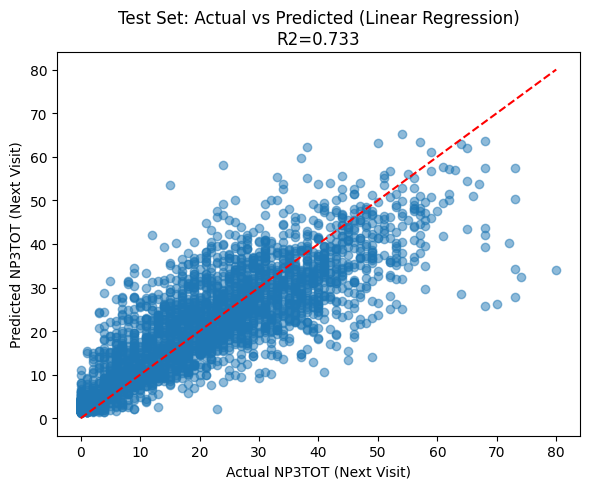

Training SVR...
SVR: MAE=5.580, RMSE=8.010, R2=0.733


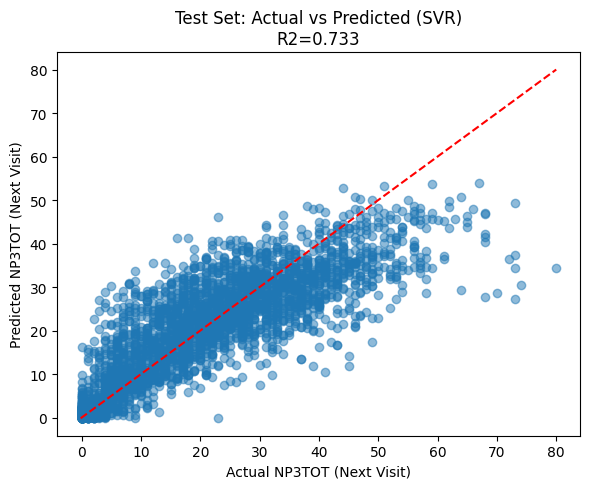

Training RandomForest Regressor...
RandomForest Regressor: MAE=5.649, RMSE=8.078, R2=0.728


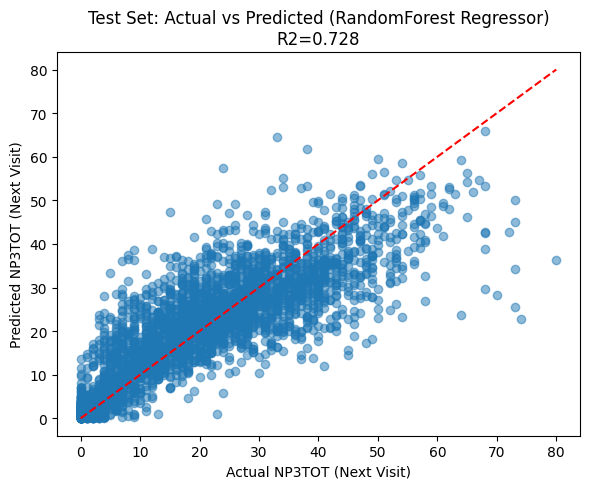

Training GradientBoosting Regressor...
GradientBoosting Regressor: MAE=5.590, RMSE=7.952, R2=0.737


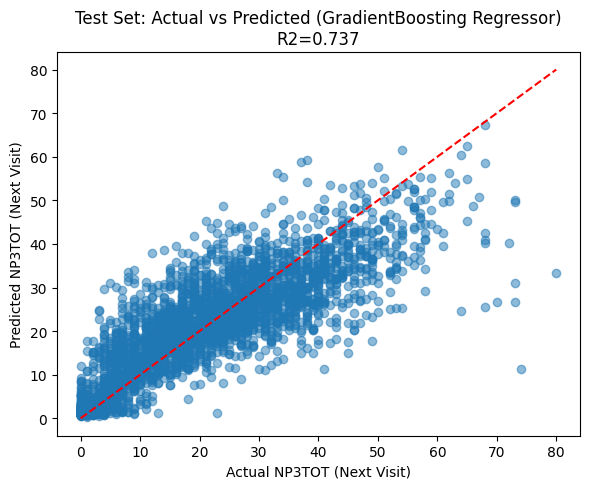

Training XGBoost...
XGBoost: MAE=5.827, RMSE=8.378, R2=0.708


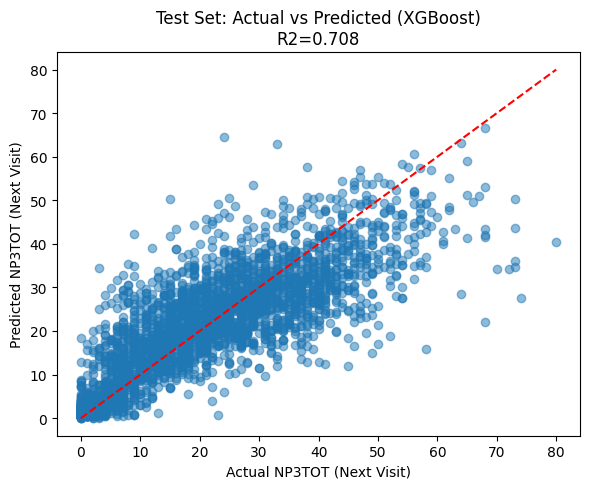

Training KNeighbors...
KNeighbors: MAE=6.072, RMSE=8.738, R2=0.682


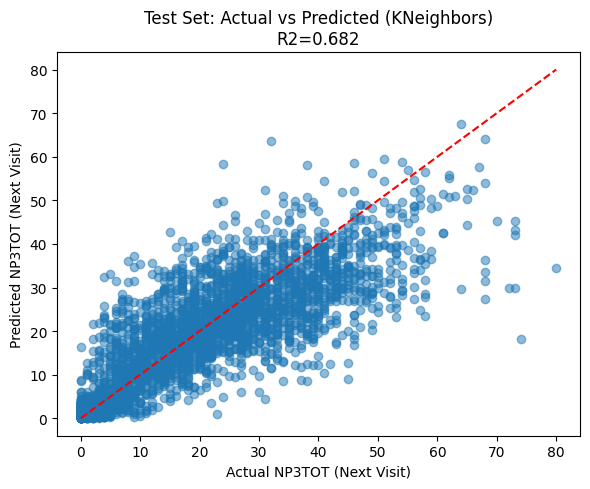

Training AdaBoostRegressor...
AdaBoostRegressor: MAE=9.787, RMSE=11.311, R2=0.467


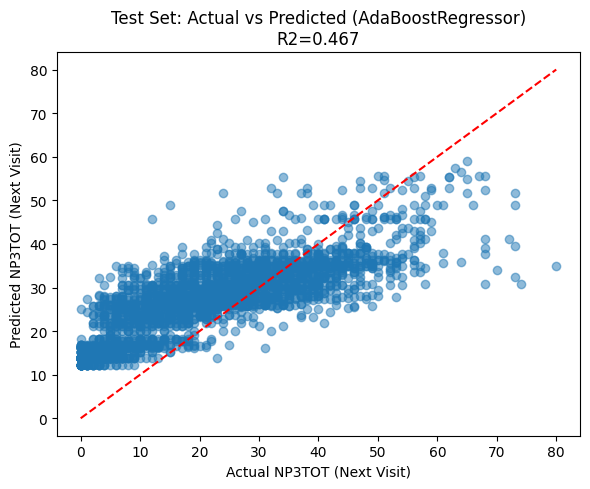

Training MLP Regressor...
MLP Regressor: MAE=5.661, RMSE=8.095, R2=0.727


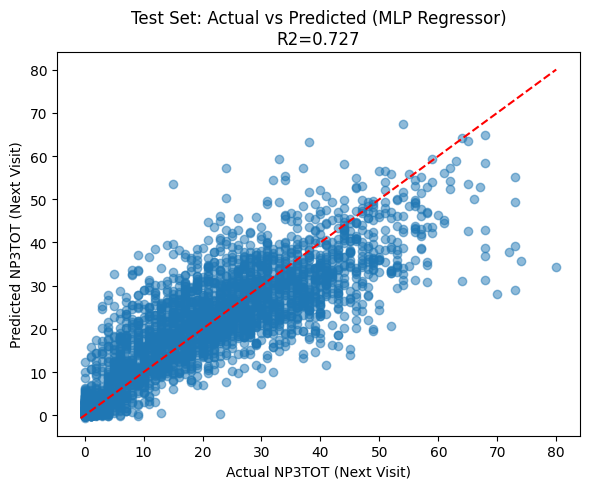


Test set results written to /Users/larsheijnen/Thesis/Modelling/Motor-PPMI/results_motor/model_results_progression_test_lag2.csv

Test Set Performance Summary:
                        Model    MAE    RMSE  R-squared
0           Linear Regression  5.708   8.000      0.733
1                         SVR  5.580   8.010      0.733
2      RandomForest Regressor  5.649   8.078      0.728
3  GradientBoosting Regressor  5.590   7.952      0.737
4                     XGBoost  5.827   8.378      0.708
5                  KNeighbors  6.072   8.738      0.682
6           AdaBoostRegressor  9.787  11.311      0.467
7               MLP Regressor  5.661   8.095      0.727


In [11]:
# ## 7. Model Training and Evaluation (Single Split)

# Define models to train (Added RandomForest)
models = {
    "Linear Regression": LinearRegression(),
    "SVR": SVR(),
    "RandomForest Regressor": RandomForestRegressor(random_state=42, n_estimators=100),
    "GradientBoosting Regressor": GradientBoostingRegressor(random_state=42),
    "XGBoost": XGBRegressor(random_state=42, objective='reg:squarederror'),
    "KNeighbors": KNeighborsRegressor(),
    "AdaBoostRegressor": AdaBoostRegressor(random_state=42),
    "MLP Regressor": MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42, early_stopping=True)
}

# Initialize results list
results_test = []

print("\n--- Evaluating on Test Set ---")
# Train and evaluate each model on the single train/test split
for name, model in models.items():
    print(f"Training {name}...")
    # --- MODIFICATION START ---
    # Convert DataFrames to NumPy arrays for fitting and prediction
    # Ensure y_train and y_test are also Series/arrays (which they should be)
    model.fit(X_train_scaled.values, y_train) # Use .values
    y_pred = model.predict(X_test_scaled.values) # Use .values
    # --- MODIFICATION END ---

    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    results_test.append({"Model": name, "MAE": mae, "RMSE": rmse, "R-squared": r2})
    print(f"{name}: MAE={mae:.3f}, RMSE={rmse:.3f}, R2={r2:.3f}")

    # Plot actual vs predicted for the test set
    plt.figure(figsize=(6, 5))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.xlabel("Actual NP3TOT (Next Visit)")
    plt.ylabel("Predicted NP3TOT (Next Visit)")
    plt.title(f"Test Set: Actual vs Predicted ({name})\nR2={r2:.3f}")
    min_val = min(y_test.min(), y_pred.min())
    max_val = max(y_test.max(), y_pred.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--') # Add y=x line
    plt.tight_layout()
    plt.show()

# Write test results to a CSV file
csv_file_test = "/Users/larsheijnen/Thesis/Modelling/Motor-PPMI/results_motor/model_results_progression_test_lag2.csv"
try:
    with open(csv_file_test, mode='w', newline='') as file:
        writer = csv.DictWriter(file, fieldnames=["Model", "MAE", "RMSE", "R-squared"])
        writer.writeheader()
        writer.writerows(results_test)
    print(f"\nTest set results written to {csv_file_test}")
except IOError as e:
    print(f"Error writing file {csv_file_test}: {e}")

# Display test results as DataFrame
results_test_df = pd.DataFrame(results_test)
print("\nTest Set Performance Summary:")
print(results_test_df.round(3))

In [12]:
# Initialize results list for CV
results_cv = []

# Define cross-validation strategy
cv = GroupKFold(n_splits=5) # Use GroupKFold


--- Evaluating with Cross-Validation (on Training Data) ---
Cross-validating Linear Regression...
Linear Regression: MAE=5.775, RMSE=8.035, R2=0.726


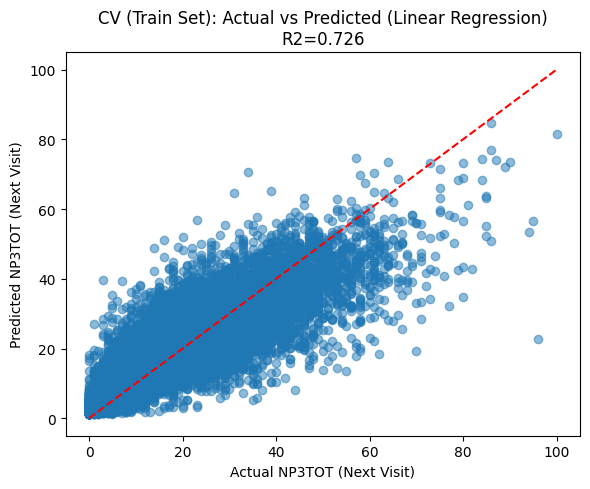

Cross-validating SVR...
SVR: MAE=5.854, RMSE=8.499, R2=0.693


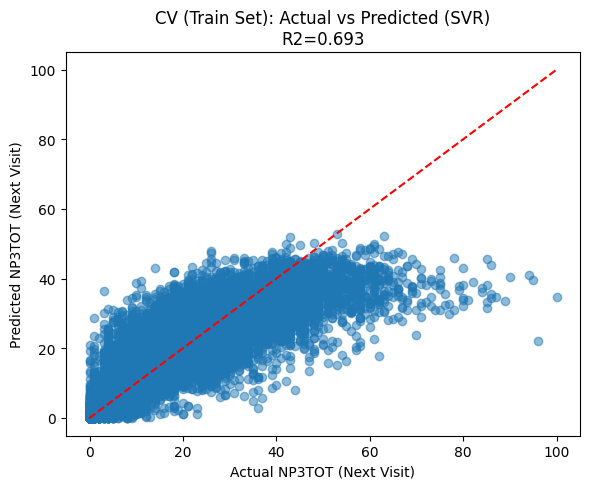

Cross-validating RandomForest Regressor...
RandomForest Regressor: MAE=5.767, RMSE=8.108, R2=0.721


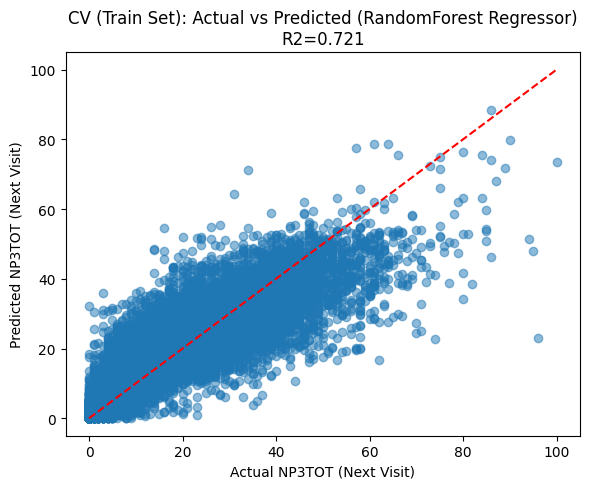

Cross-validating GradientBoosting Regressor...
GradientBoosting Regressor: MAE=5.693, RMSE=7.998, R2=0.728


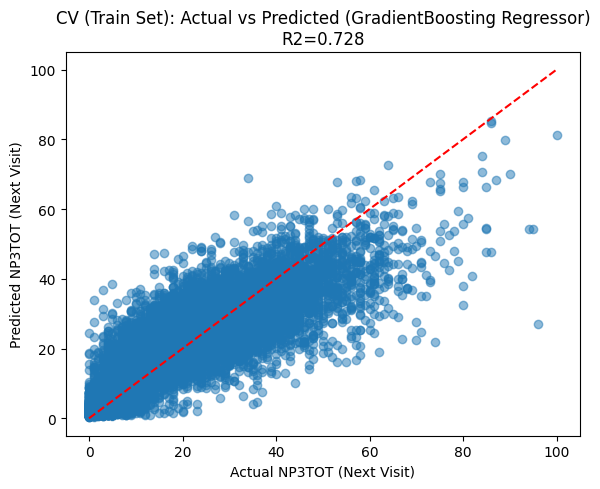

Cross-validating XGBoost...
XGBoost: MAE=5.977, RMSE=8.497, R2=0.693


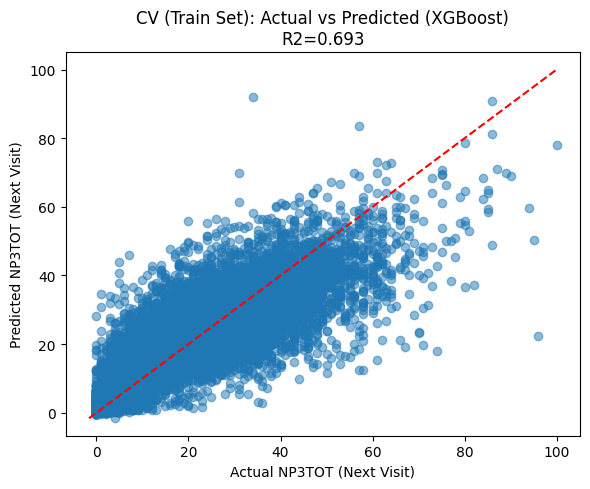

Cross-validating KNeighbors...
KNeighbors: MAE=6.319, RMSE=8.950, R2=0.660


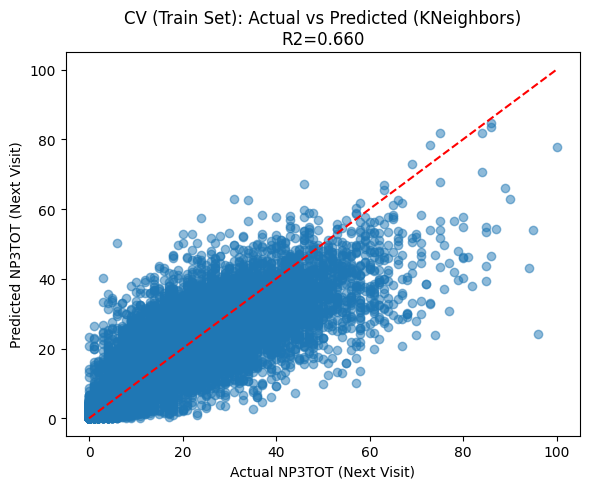

Cross-validating AdaBoostRegressor...
AdaBoostRegressor: MAE=9.298, RMSE=10.946, R2=0.491


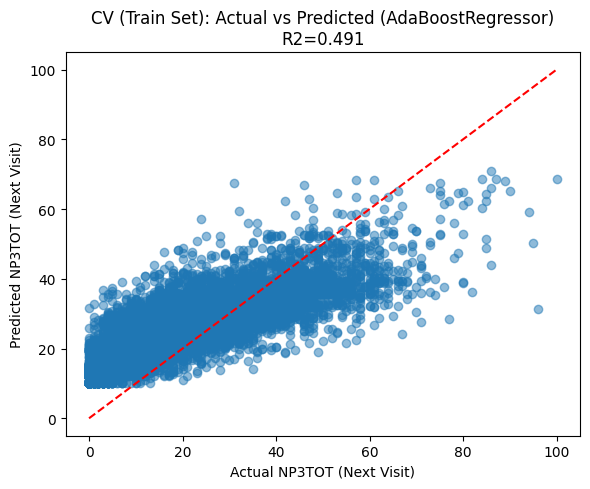

Cross-validating MLP Regressor...
MLP Regressor: MAE=5.804, RMSE=8.156, R2=0.717


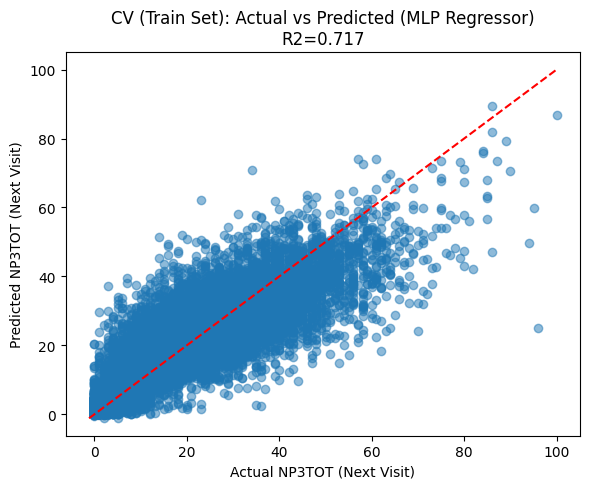


Cross-validation results written to /Users/larsheijnen/Thesis/Modelling/Motor-PPMI/results_motor/model_results_progression_test__cv_lag2.csv

Cross-Validation Performance Summary (on Training Data):
                        Model    MAE    RMSE  R-squared
0           Linear Regression  5.775   8.035      0.726
1                         SVR  5.854   8.499      0.693
2      RandomForest Regressor  5.767   8.108      0.721
3  GradientBoosting Regressor  5.693   7.998      0.728
4                     XGBoost  5.977   8.497      0.693
5                  KNeighbors  6.319   8.950      0.660
6           AdaBoostRegressor  9.298  10.946      0.491
7               MLP Regressor  5.804   8.156      0.717


In [14]:
# ## 8. Cross-Validation (Group-Based)

# Initialize results list for CV
results_cv = []

# Define cross-validation strategy
cv = GroupKFold(n_splits=5) # Use GroupKFold

print("\n--- Evaluating with Cross-Validation (on Training Data) ---")

for name, model in models.items():
    print(f"Cross-validating {name}...")

    # --- MODIFICATION START ---
    # Get cross-validated predictions on the scaled training data (NumPy array)
    y_pred_cv = cross_val_predict(model, X_train_scaled.values, y_train, groups=groups_train, cv=cv) # Use .values
    # --- MODIFICATION END ---

    mae_cv = mean_absolute_error(y_train, y_pred_cv)
    rmse_cv = np.sqrt(mean_squared_error(y_train, y_pred_cv))
    r2_cv = r2_score(y_train, y_pred_cv)

    results_cv.append({"Model": name, "MAE": mae_cv, "RMSE": rmse_cv, "R-squared": r2_cv})
    print(f"{name}: MAE={mae_cv:.3f}, RMSE={rmse_cv:.3f}, R2={r2_cv:.3f}")

    # Plot actual vs predicted for CV
    plt.figure(figsize=(6, 5))
    plt.scatter(y_train, y_pred_cv, alpha=0.5)
    plt.xlabel("Actual NP3TOT (Next Visit)")
    plt.ylabel("Predicted NP3TOT (Next Visit)")
    plt.title(f"CV (Train Set): Actual vs Predicted ({name})\nR2={r2_cv:.3f}")
    min_val = min(y_train.min(), y_pred_cv.min())
    max_val = max(y_train.max(), y_pred_cv.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--') # Add y=x line
    plt.tight_layout()
    plt.show()


# Write CV results to a CSV file in the specified directory
csv_file_cv = "/Users/larsheijnen/Thesis/Modelling/Motor-PPMI/results_motor/model_results_progression_test__cv_lag2.csv"
try:
    with open(csv_file_cv, mode='w', newline='') as file:
        writer = csv.DictWriter(file, fieldnames=["Model", "MAE", "RMSE", "R-squared"])
        writer.writeheader()
        writer.writerows(results_cv)
    print(f"\nCross-validation results written to {csv_file_cv}")
except IOError as e:
    print(f"Error writing file {csv_file_cv}: {e}")

# Display CV results as DataFrame
results_cv_df = pd.DataFrame(results_cv)
print("\nCross-Validation Performance Summary (on Training Data):")
print(results_cv_df.round(3))